# Lab 5: Understanding Variational Autoencoders (VAE)



------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

In this notebook, you will complete the code to train a VAE for a dataset of images of celebrities: [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). We will use a reduced set of 11.000 images to speed things up.


### Probabilistic model

The probabilistic model to fit to the data is exactly the same one seen in class. If $\mathbf{x}^{(i)}$ are the training images and $\mathbf{z}^{(i)}$ are the corresponding latent (unobserved) embeddings of dimension $k$, $i=1,\ldots,11.000$. Then ...

\begin{align}
p(\mathbf{z}) &= \mathcal{N}(\mathbf{0},\mathbf{I})\\
p(\mathbf{x}|\mathbf{z}) &= \mathcal{N}(\mu_\theta(\mathbf{z}),\sigma_x\mathbf{I})
\end{align}
where $\mu_\theta(\mathbf{z})$ is a Neural Network with input $\mathbf{z}$ and $\sigma_x$ is a reconstruction noise power that we won't train. By default, we will take the value $\sigma_x=0.1$.

### Inference model

We will approximate the posterior distribution $p(\mathbf{z}|\mathbf{x})$ by the following parametric model

$$p(\mathbf{z}|\mathbf{x})\approx q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mu_\eta(\mathbf{x}),\text{diag}(\sigma_\eta(\mathbf{x}))$$

where both $\mu_\eta(\mathbf{x}),\text{diag}(\sigma_\eta(\mathbf{x})$ are neural networks with input $\mathbf{x}$.

### Training loss: the evidence lower bound (ELBO)

Since exact inference is intractable in the former model, we will train the parameters of the probabilistic and inference models using the ELBO lower bound

$$\log p(\mathbf{x}) \geq \mathbb{E}_{q(\mathbf{z}|\mathbf{x})}\left[\log p(\mathbf{x}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{x}||p(\mathbf{z}))$$

Since $p(\mathbf{z})=\mathcal{N}(\mathbf{0},\mathbf{I})$ and $q(\mathbf{z}|\mathbf{x})$ are both Gaussian then

$$D_{KL}(q(\mathbf{z}|\mathbf{x}||p(\mathbf{z})) = \frac{1}{2}\left(-k+\sum_{j=1}^k \sigma_{\eta,j}-\log(\sigma_{\eta,j})+\mu_{\eta,j}^2\right)$$

During training, the first expectation will be replaced by a one-sample Monte Carlo estimate for every data point. Overall, the ELBO to be optimized using SGD is

$$\text{ELBO}(\theta,\eta,\sigma_x) = \frac{1}{N} \sum_{i=1}^{N} \left(\log p(\mathbf{x}^{(i)}|\tilde{\mathbf{z}}^{(i)}) - D_{KL}(q(\mathbf{z}|\mathbf{x}^{(i)}||p(\mathbf{z}))\right)$$

where $\tilde{\mathbf{z}}^{(i)}$ is a sample from $q(\mathbf{z}|\mathbf{x}^{(i)})$ computed as

$$\tilde{\mathbf{z}}^{(i)} =  \mu_\eta(\mathbf{x}) + \sqrt{\sigma_\eta(\mathbf{x})} \epsilon$$
and $\epsilon$ is a sample from a k-dimensional standard Gaussian distribution. This is the **reparameterization trick**. Note that samples are differentiable w.r.t. the parameters in both $\mu_\eta(\mathbf{x})$ and $\sigma_\eta(\mathbf{x})$.

In [1]:
import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import time
import math

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Part I: Loading the reduced CelebA dataset

First, import to your own Drive the folder I shared with you in Aula Global.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


With the following function we import the database using Pytorch dataloaders ...

In [4]:
def get_celeba(batch_size, dataset_directory):

    train_transformation = transforms.Compose([
        transforms.Resize((64, 64)),        # THE IMAGES ARE RE-SCALED TO 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    train_dataset = torchvision.datasets.ImageFolder(dataset_directory, train_transformation)


    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(train_dataset)))

    # Prepare Data Loaders for training and validation
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)

    return trainloader

In [ ]:
# We load the database in a single trainloader

In [5]:
trainloader = get_celeba(32,'/content/drive/MyDrive/Neuralnetworks-Projects/project4/CarolMaria/reduced_celebA/celeba')

In the following code, we read one mini-batch of images and plot some of them.

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

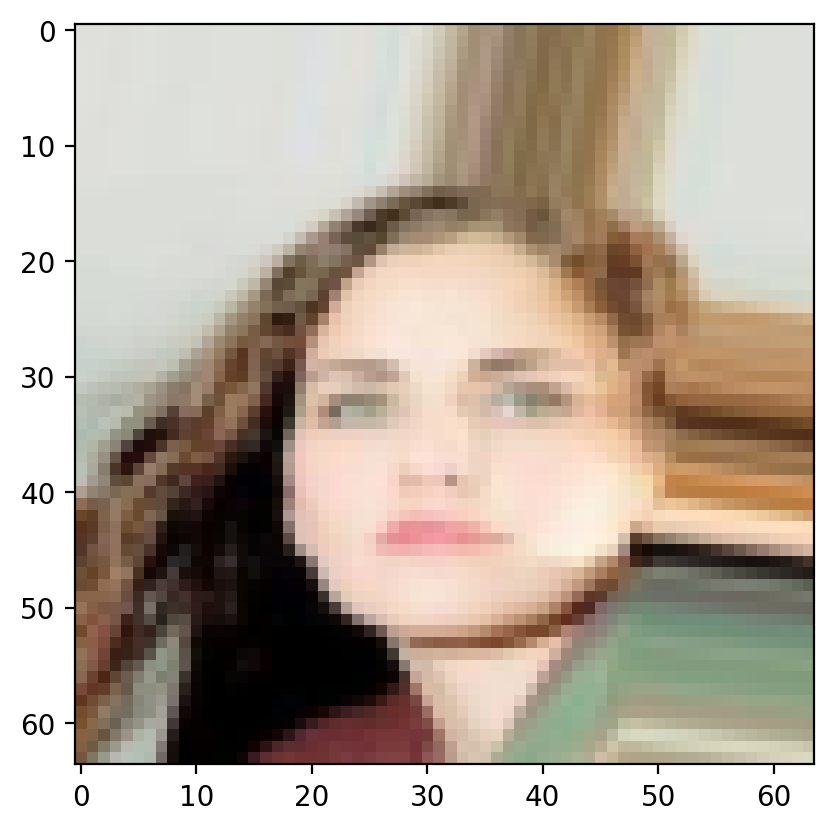

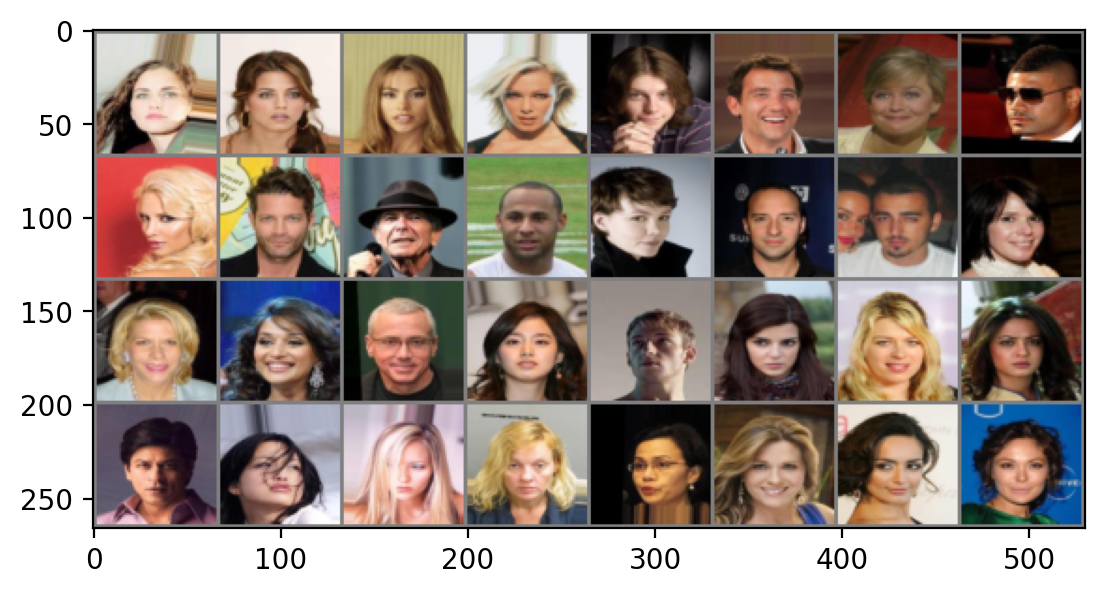

In [7]:
train = iter(trainloader)

i,l = next(train)

imshow(i[0,:,:,:])

imshow(torchvision.utils.make_grid(i))

## A class to implement the encoder mean and variance

With the following class, we implement the CNN network to obtain both $\mu_\eta(\mathbf{x}), \sigma_\eta(\mathbf{x})$, which determine the moments of the approximate posterior distribution $q(\mathbf{z}|\mathbf{x})$.

We use a single CNN with input $\mathbf{x}$, the output vector of dimension $2k$ is divided in two parts. The first $k$ elements represent the mean, and we compute the variance from the last $k$ elements using a soft-plus.

The actual design of this network is borrowed from [this paper](https://paperswithcode.com/method/beta-vae). It could be improved by adding batch norm layers, but you will see it does perform well already.

> **Exercise**: Complete the following code. What are the spatial dimensions of the 256 feature maps at the ouput of the `conv5` convolutional layer?

In [8]:
class encoder(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):


        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # self.conv1 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32,
                               kernel_size=4, stride=2, padding=1)

        self.relu = nn.ReLU()

        # self.conv2 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                       kernel_size=4, stride=2, padding=1)

        # self.conv3 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=4, stride=2, padding=1)

        # self.conv4 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64,
                       kernel_size=4, stride=2, padding=1)

        # self.conv5 is a convolutional layer, with 256 output channels, kernel size 4, stride 1,
        # and padding 0

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256,
                               kernel_size=4, stride=1, padding=0)


        # self.linear is a linear layer with dimz*2 outputs
        self.linear = nn.Linear(in_features=256, out_features=dimz*2)  ### TAKES 256 FEATURES FROM LAST CONVOLUTIONAL LAYER

        self.softplus = nn.Softplus()

    def forward(self,x):

        # The forward method to project and image into a 2dimz dimensional vector

        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z)) ### applies conv2 to the output of conv1 and passes it through ReLU.
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))   ### This applies conv4 to the output of conv3 and passes it through ReLU.
        z = self.relu(self.conv5(z))
        # Transform z into a 256-dim vector
        z = z.view(-1, 256)       ### reshapes the tensor to be 2D with 256 features per sample.
        z = self.linear(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):

        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method

        z = self.forward(x)  # Call the forward method to get encoded representation

        # The mean is the first dimz components of the forward output
        mu = z[:, :self.dimz]  # Extract first dimz elements as the mean

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample


Input images are resized to 64x64 pixels with 3 channels (RGB).
First convolutional layer (conv1): 32 output channels, kernel size 4, stride 2, padding 1 and the output dimensions are 32x32x32. Then, in conv2 they are 16x16x32. For the third convolutional layer (conv3): 64 output channels, kernel size 4, stride 2 and padding 1, the output dimensions are 8x8x64. Afer in conv4,  4x4x64.
Finally, in conv5, and following these calculations the dimensions are  1x1x256.

Output dimensions calculation:

Formula: ((input_size - kernel_size + 2*padding)/stride) + 1
Width: ((4 - 4 + 2*0)/1) + 1 = 1
Height: ((4 - 4 + 2*0)/1) + 1 = 1

Therefore, the 256 feature maps at the output of the conv5 convolutional layer have spatial dimensions of 1x1. We are flattening the spatial information into a set of 256 features, which explains why the following layer is a linear layer that takes 256 input features and maps them to dimz*2 outputs (for mean and variance vectors).
This architecture progressively reduces the spatial dimensions through strided convolutions while increasing the number of channels

> **Exercise**: Using `dimz=2`, create an encoder object and print the mean `mu_z` and variance `var z` in the z space for one image.

In [9]:
my_enc = encoder(dimz=2)
train = iter(trainloader)
i, l = next(train)
mu_z, var_z, sample_z = my_enc.encode_and_sample(i)
print("Mean shape:", mu_z.shape)
print("Variance shape:", var_z.shape)
print("Mean:", mu_z[0])
print("Variance:", var_z[0])

Mean shape: torch.Size([32, 2])
Variance shape: torch.Size([32, 2])
Mean: tensor([ 0.0072, -0.0510], grad_fn=<SelectBackward0>)
Variance: tensor([0.6865, 0.6847], grad_fn=<SelectBackward0>)


## A class to implement the decoder mean

Given a sample from $\mathbf{z}$, we generate images by sample from $p(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mu_\theta(\mathbf{z}),\sigma_x\mathbf{I})$, where we take $\sigma_x=0.1$ as a reconstruction noise. The following class implements the mean NN $\mu_\theta(\mathbf{z})$ using transpose convolutions. Again, the network design comes from the same [this paper](https://paperswithcode.com/method/beta-vae).

> **Exercise**: complete the following code. Why do we use an hiperbolic tangent output activation?


In [10]:
class decoder(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        # We expand z into a 256 dimensional vector

        self.linear = nn.Linear(dimz,256)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # self.tconv1 is a convolutional layer, with 64 output channels, kernel size 4, stride 1,
        # and padding 0

        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1,padding=0)

        # self.tconv2 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)

        # self.tconv3 is a convolutional layer, with channels output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv5 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2,padding=1)

    def forward(self,z):

        x = self.relu(self.linear(z).view(-1,256,1,1))
        x = self.relu(self.tconv1(x))   ### applies tconv1 to the output of the linear layer and passes it through ReLU.
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.relu(self.tconv4(x))
        x = self.tanh(self.tconv5(x))   ### applies tconv5 to the output of tconv4 and passes it through tanh to normalize the output to [-1, 1], which matches the normalized input range.
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

> **Exercise:** create a decoder object using again `dimz=2`. Given the mean projection of an image `mu_z` that you obtained before, use the decoder to obtain the mean `x_mean` of $p(\mathbf{x}|\mathbf{z})$. Represent one original image versus the reconstruction. Obviously, since you have not trained the model yet, do expect too much.

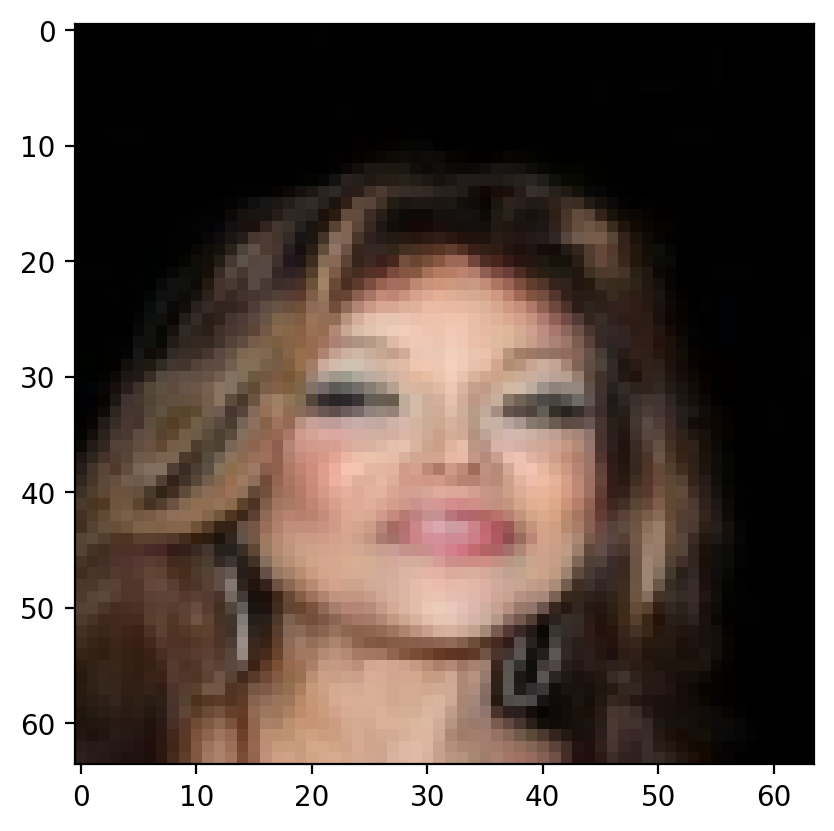

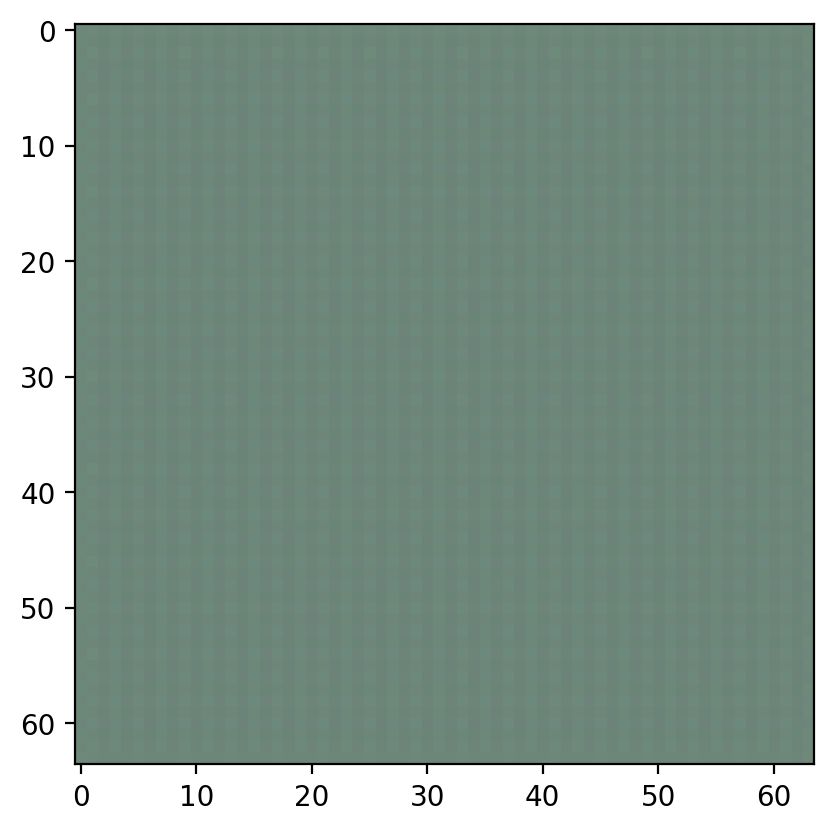

In [11]:
my_dec = decoder(dimz=2)

x_mean = my_dec.decode(mu_z).detach()

imshow(i[0,:,:,:]) # first image (index 0) from the batch while keeping all the channels, height, and width dimensions.

imshow(x_mean[0,:,:,:]) # reconstructed image, output from your decoder which has attempted to reconstruct the input image after passing through the VAE's bottleneck (the latent space)

Observe that, since the mean `x_mean` is so different from the real image, then the real image is **extremely unlikely** in the distribution $p(\mathbf{x}|\mathbf{z})$. The model will never generate it by sampling.

For one image `x`, the following function evaluates the log-likelihood of an independent Gaussian distribution given the mean and the diagonal covariance matrix. In the function, both `x` and `mu_x` are passed as images and internally stacked to vectors. `var_x` is a constant. Recall that `var_x` is a constant vector of 0.1 elements.



In [12]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images. It has dimension [Batch,3,dimx,dimx]

    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,3,dimx,dimx]

    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

> **Exercise:** Compute the log-likelihood of one real image given `x_mean` computed above and `var_x=0.1`.

tensor(-616207.6875)


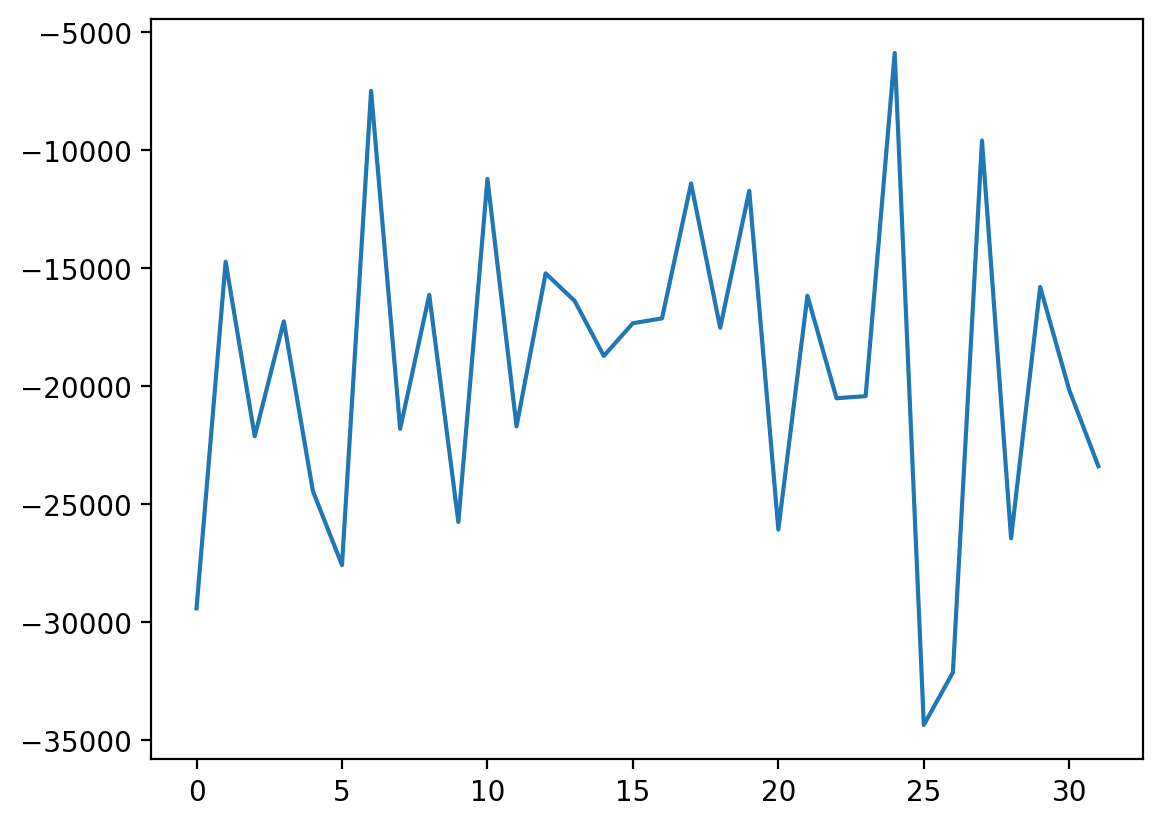

In [13]:
var_x = 0.1

logp, logp_data = eval_Gaussian_LL(i, x_mean, var_x)   ### computes the log-likelihood of the original images given the reconstructed images and the variance.

print(logp)

plt.plot(np.arange(0,32),logp_data)

we can see the y-axis shows extremely negative log-likelihood values, which indicates very poor reconstruction quality. Each point represents one of the 32 images in the batch. Also, the relatively flat line suggests that all images are being reconstructed with similar (poor) quality.

We found these results because the model hasn't been trained yet and there is a huge discrepancy between the original images and their reconstructions. Additionally, with a small variance (var_x = 0.1), the model is very "confident" about its poor reconstructions, which results in an extremely negative log-likelihood.

## The variational autoencoder class

The following class puts together the VAE encoder & decoder and also defines the ELBO lower bound. We will extend it later to incorporate training methods.

> **Exercise**: complete the following code.

In [14]:
class VAE(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        self.var_x = var_x

        self.dimz = dimz

        # We create an encoder network

        self.encoder = encoder(dimz, channels, var_x)  ### creates an encoder with the given parameters.

        # We create a decoder network

        self.decoder = decoder(dimz, channels, var_x)  ### encodes the input images and gets the mean, variance, and a sample from the posterior distribution.

    def forward(self,x):

        # In the forward method, we return the mean and variance
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the
        # encoder's posterior distribution.

        mu_z, var_z, sample_z = self.encoder.encode_and_sample(x)

        # Decoder provides the mean of the reconstruction

        mu_x = self.decoder.decode(sample_z)

        return mu_x,mu_z,var_z

    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp, _ = eval_Gaussian_LL(x, mu_x, self.var_x)  ### computes the log-likelihood of the original images given the reconstructed images.

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz

> **Exercise:** Create a VAE object for `dimz=2` and evaluate the ELBO using `mu_z`, `var_z`, and `x_mean` computed above.

In [ ]:
my_vae = VAE(dimz=2, channels=3, var_x=0.1)   ### creates a VAE with latent dimension 2, 3 input channels, and reconstruction variance 0.1.

print(my_vae.loss_function(i,x_mean,mu_z,var_z))


(tensor(623367.5000, grad_fn=<AddBackward0>), tensor(623365.5000), tensor(1.9923, grad_fn=<MulBackward0>))


First value (605317.5625): Total loss (negative ELBO = -logp + KLz). It's very large, meaning poor model performance, as expected before training.

Second value (605315.6875): Negative log-likelihood (-logp), indicating very poor reconstructions due to random weight initialization.

Third value (1.8): KL divergence, small compared to reconstruction error, showing the latent space is already somewhat close to the prior.

The loss is dominated by reconstruction error, typical at the start of VAE training. As training progresses, reconstruction error should drop significantly, KL divergence may rise slightly but stay controlled, and overall loss should decrease, leading to better reconstructions and compression.

## Incorporating a training method

The following class completes the implementation of the VAE. **You do not have to edit anything**, but it is highly recommended to go through the code. It is actually very similar to the training classes we have been implementing. Only three points to remark:


- Since training is pretty slow (every epoch can take a few minutes), we save the model every few minibatches. User indicates the saving path using the `save_folder` argument.
- I have introduced a `restore` flag. When set it to true, we load the model parameters from a file saved in the `save_folder` argument.
- The class also incorporates a method to sample from the generative model. Namely, create new images. To this end, we sample $\mathbf{z}$ from $p(\mathbf{z}) = \mathcal{N}(0,I)$ and then we return the mean of $p(\mathbf{x}|\mathbf{z})$.

In [15]:
class VAE_extended(VAE):

    def __init__(self, dimz=2,  channels=3, var_x=0.1,lr=1e-3,epochs=20,save_folder='./',restore=False):

        super().__init__(dimz,channels=3,var_x=0.1)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.save_folder = save_folder

        if(restore==True):
            state_dict = torch.load(self.save_folder+'VAE_checkpoint.pth')
            self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            idx_batch = 0

            for images, labels in trainloader:

                images = images.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(images)

                loss, rec, kl_l = self.loss_function(images,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item()

                self.optim.step()

                if(idx_batch%10==0):

                    torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')

                idx_batch += 1

            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            if(e%1==0):

                torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

        with torch.no_grad():

            eps = torch.randn([num_imgs,self.dimz]).to(self.device)

            x_sample = self.decoder.decode(eps)

            return x_sample.to("cpu").detach()

# Validate a pre-trained model

First, we're going to see a VAE model in action. In the file `VAE_checkpoint.pth` linked in Aula Global, I give you the parameters of a VAE with `dim_z=50` trained for 200 epochs with `var_x=0.1`, `lr=1e-3`.

> **Exercise**: Create a VAE with the parameters contained in the file `VAE_checkpoint.pth`. To do so, instantiate the class `VAE_extended` with the `restore_flag` set to `True`.

In [16]:
path_to_save = '/content/drive/MyDrive/Neuralnetworks-Projects/project4/CarolMaria/' # UPDATE THIS ACCORDING TO YOUR PATH!
my_vae = VAE_extended(dimz=50, channels=3, var_x=0.1, save_folder=path_to_save, restore=True)

### VAE with latent dimension 50, 3 input channels, reconstruction variance 0.1, and loads the pretrained model from the specified folder.

> **Exercise:** Using the method `sample` from the clase `VAE_extended`, generate 20 images from the probabilistic model. **Note these are images created by our model! They correspond to people that do not exist!**.

There are many variants of VAEs that quite improve these results, but even this vanilla VAE we have implemented does a pretty god job! Despite the images contain lots of artifacts, note that the images contain lots of very realistic details. Also note how the model tries to vary the features of the images (hair, background, smiles etc ...).

In [17]:
x = my_vae.sample(20)

we observe blurry results since basic VAE

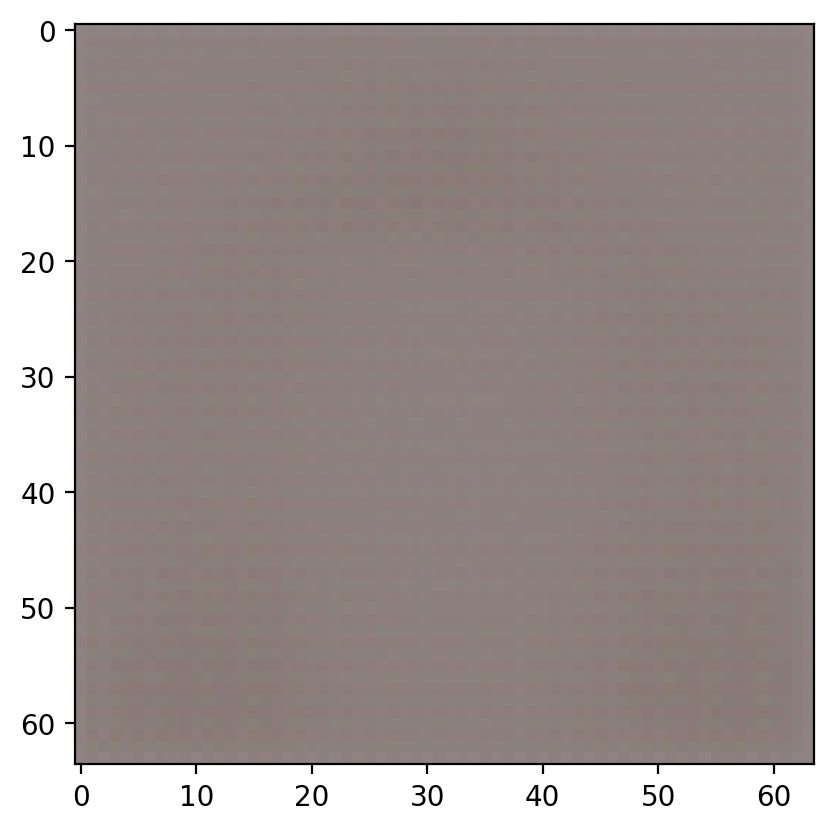

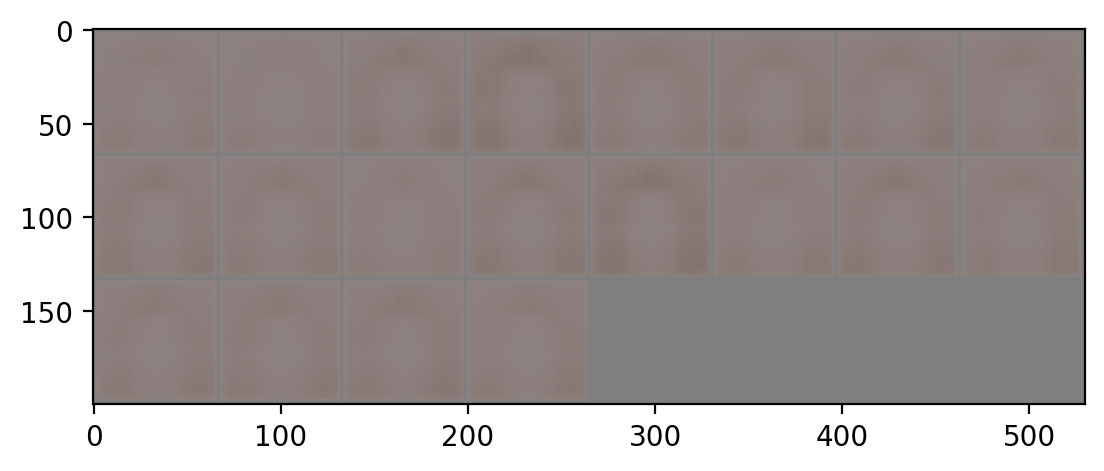

In [18]:
imshow(x[0,:,:,:])

imshow(torchvision.utils.make_grid(x))

> **Exercise:** Compare a real image versus its reconstruction. Note that the model is by default save in a GPU if available, so you have to move the images there. To visualize reconstructed images, you have to move the result of the decoder back to CPU.

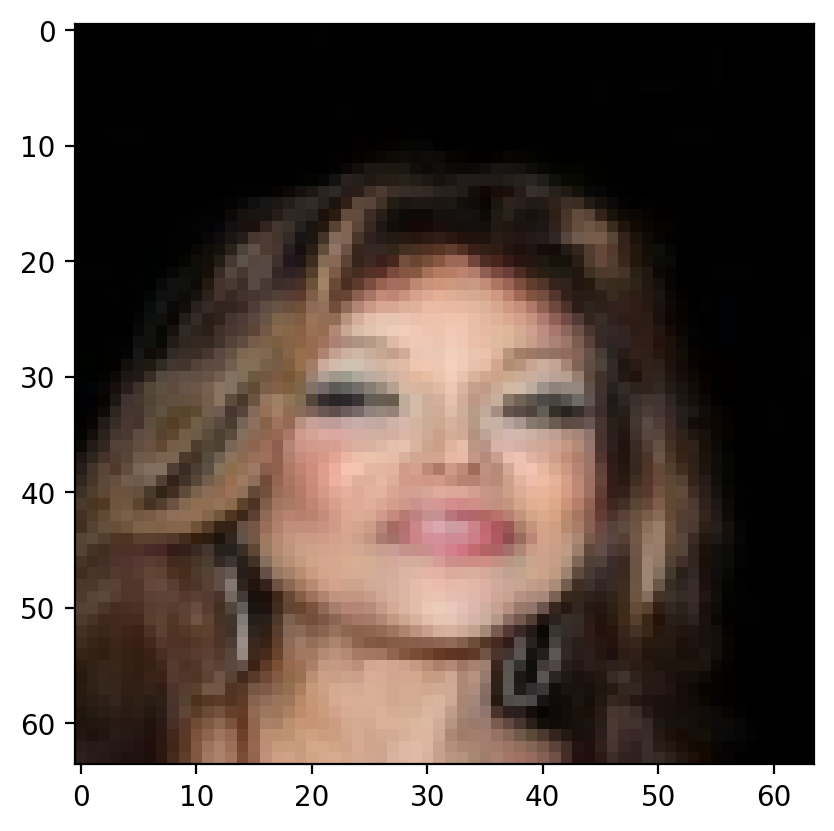

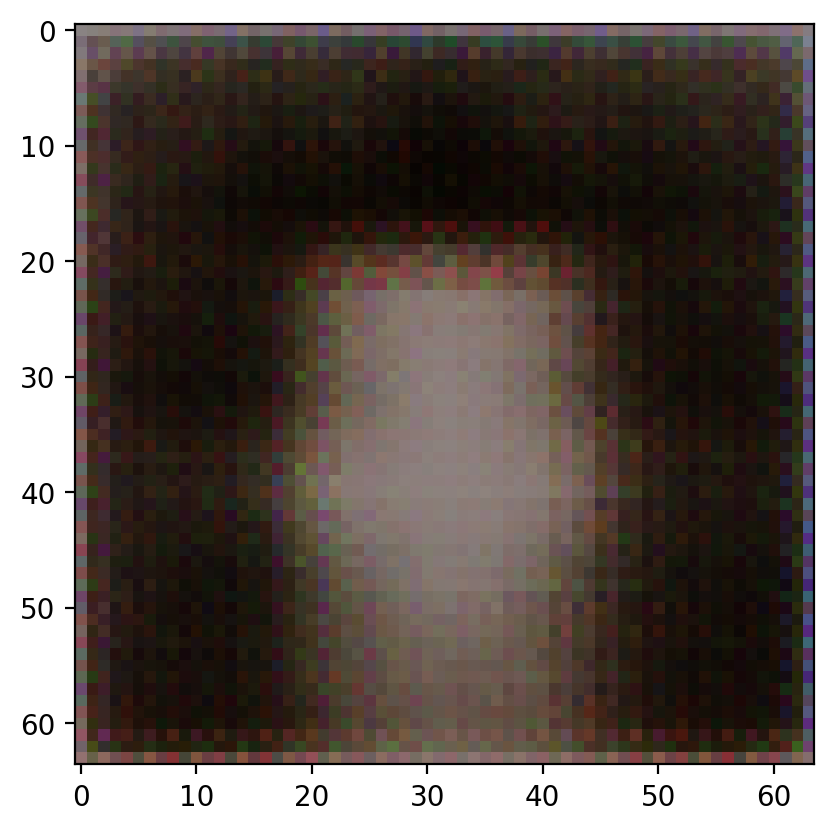

In [19]:
z_batch, _, _ = my_vae.encoder.encode_and_sample(i.to(my_vae.device))   ### encodes the input images using the encoder.

x_reconstructed = my_vae.decoder.decode(z_batch).detach()

# We plot the original image
imshow(i[0,:,:,:])

# And the reconstruction
imshow(x_reconstructed.cpu()[0,:,:,:])


> Using the VAE, we can also *interpolate* between images. Namely, given the latent representation $\mathbf{z}_1$ and $\mathbf{z}_2$ of two images, we can visualize the images that correspond to different linear interpolations between both latent points. To this end, given $w=[0,0.1,0.2, ...,1]$, will visualize the mean of $p(\mathbf{x}|\mathbf{z})$ for

$$z = (1-w)\mathbf{z}_1+w\mathbf{z}_2$$

**Exercise:** Complete the following code to interpolate between two images

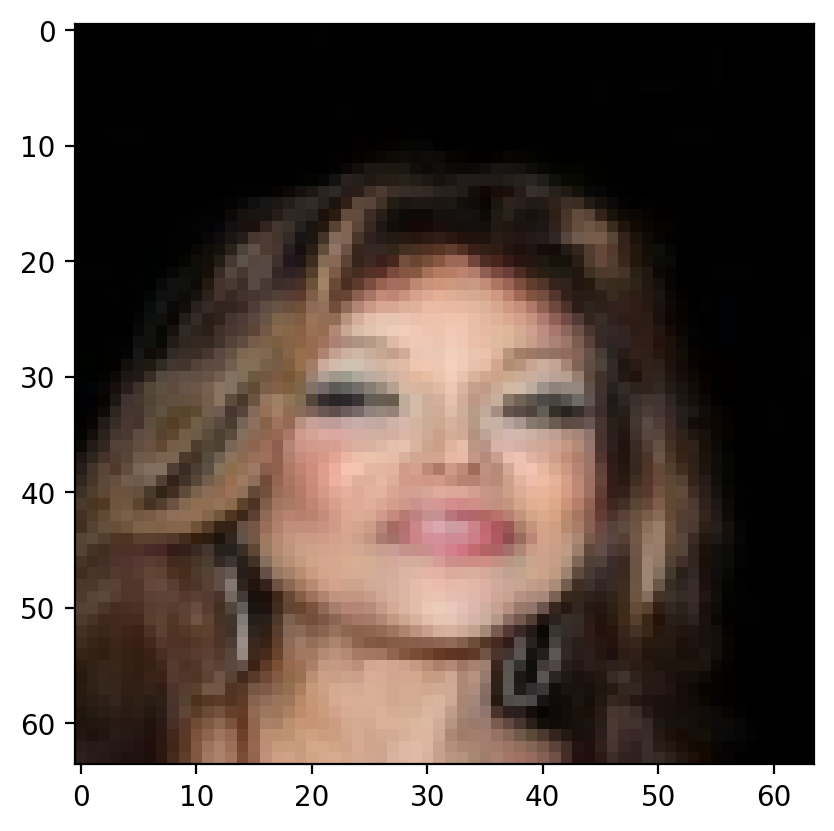

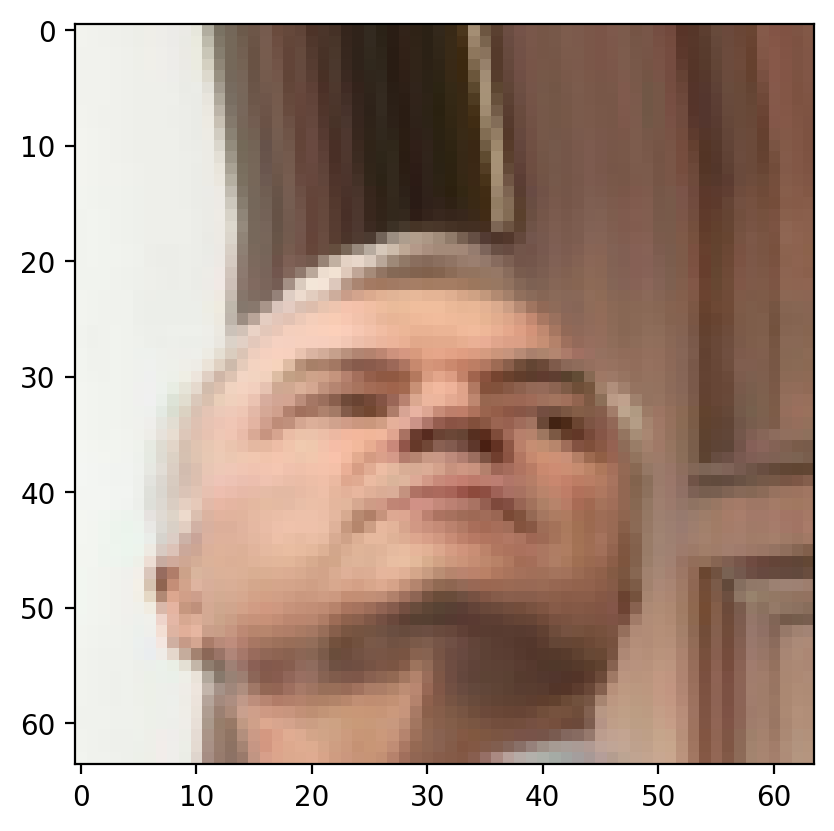

In [20]:
# Lets visualize the images to interpolate

img_1 = i[0,:,:,:]
img_2 = i[1,:,:,:]

imshow(img_1)

imshow(img_2)


In [21]:
# z_1 and z_2 are saved in z_batch, computed in the previous exercise

z_1 = z_batch[0:1,:]
z_2 = z_batch[1:2,:]

# Linear interpolation

weight = torch.Tensor(1.0-np.arange(0,10,1)/10)

reconstructed_image = [my_vae.decoder.decode(z_1*w+z_2*(1-w)).to('cpu').detach() for w in weight]

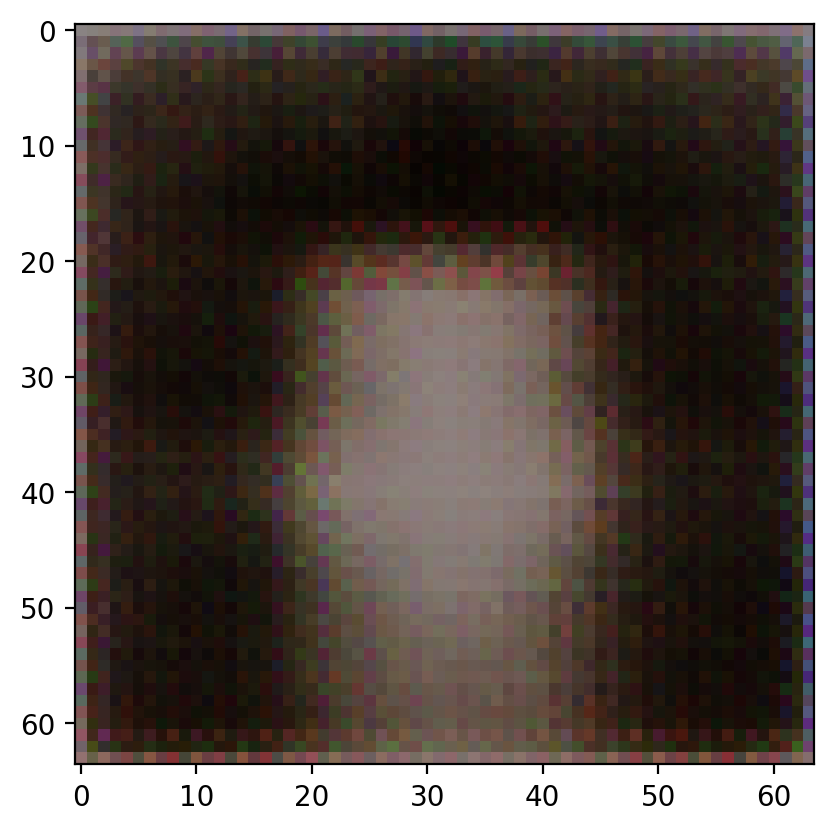

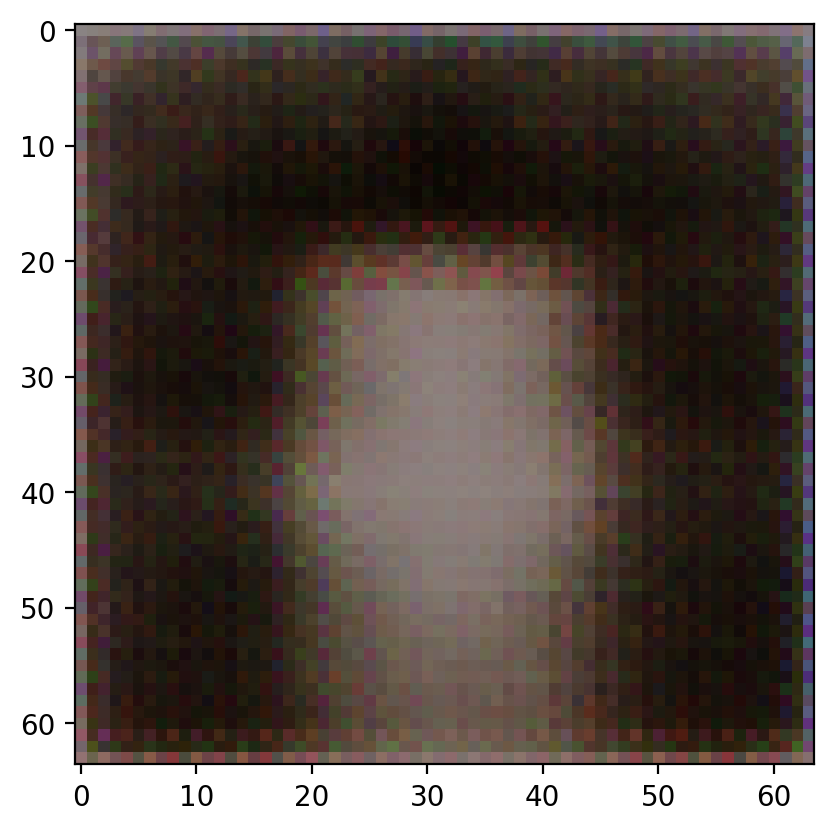

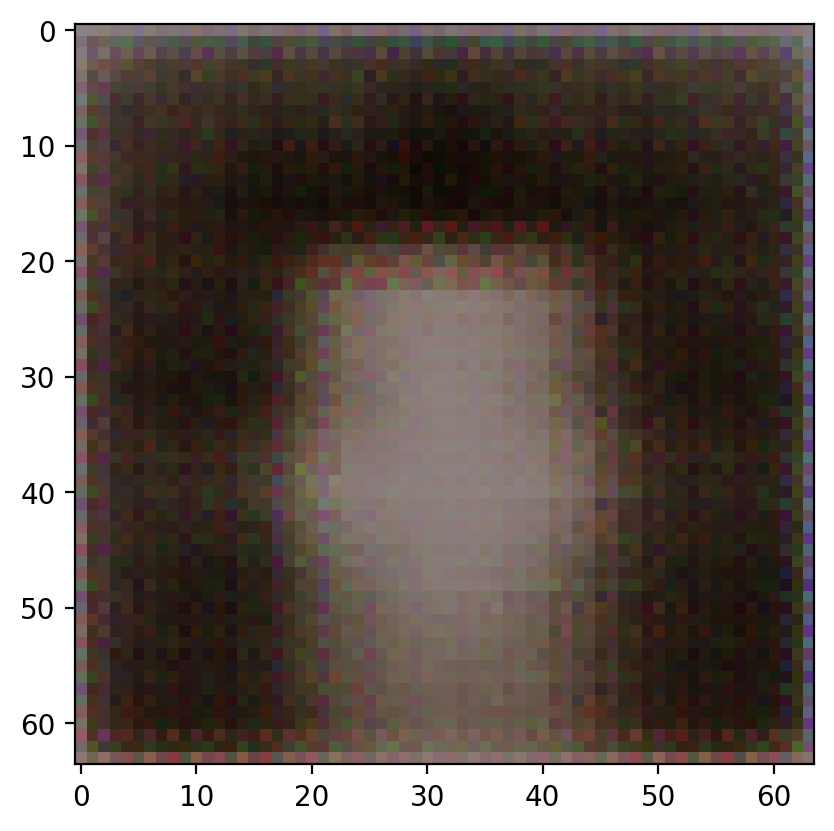

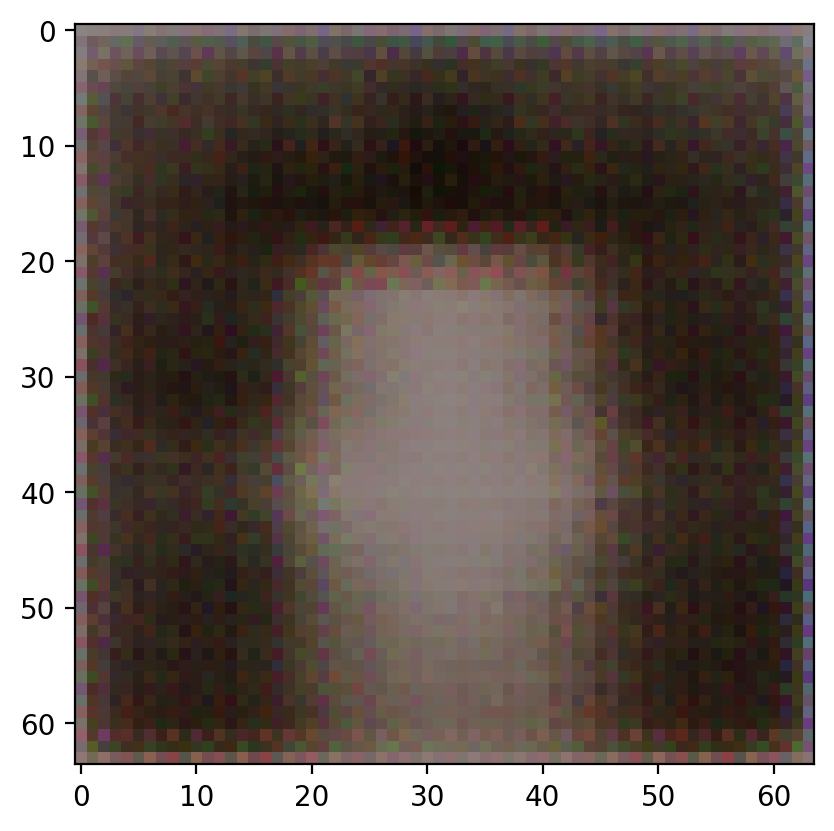

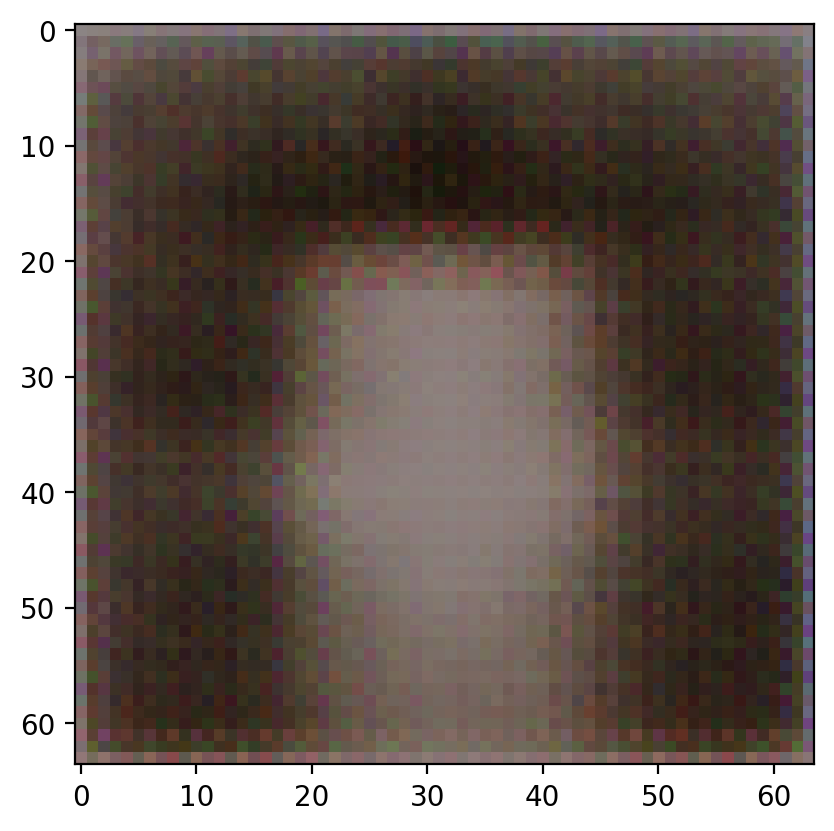

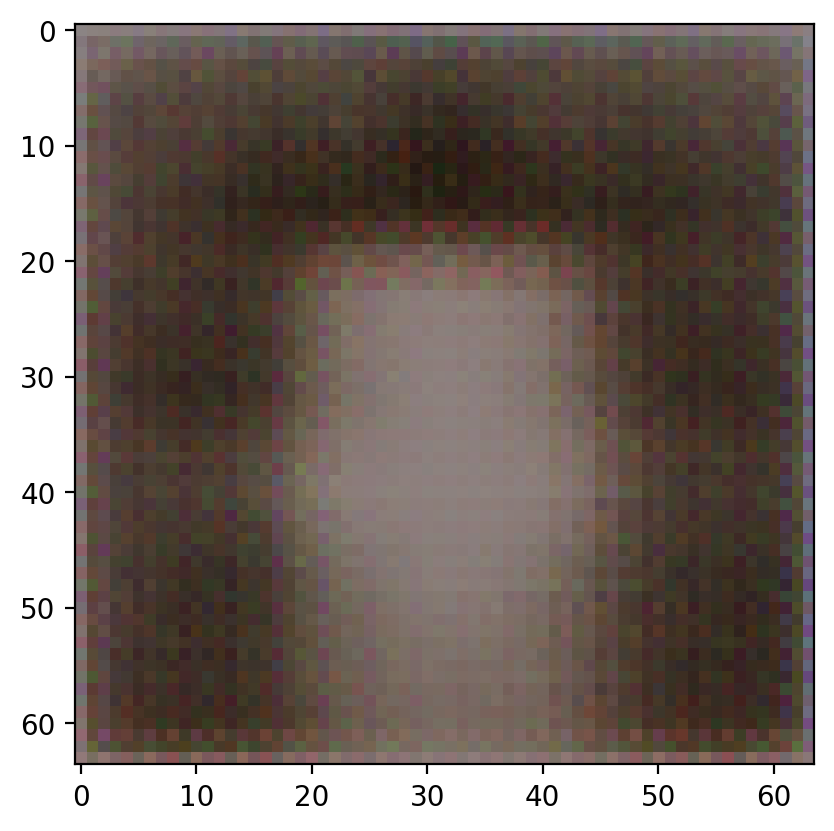

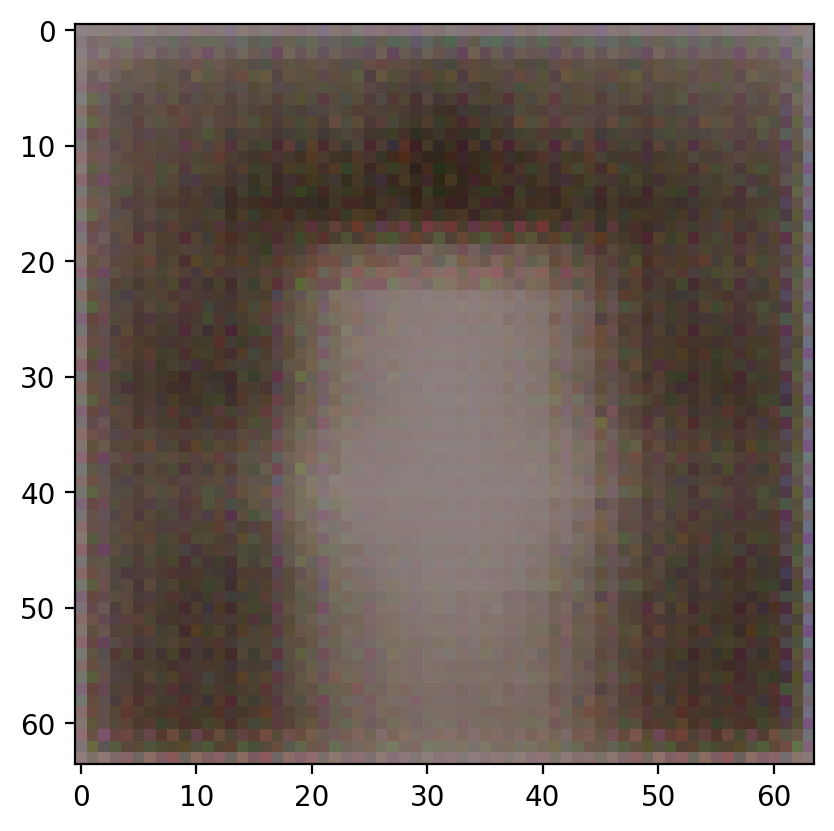

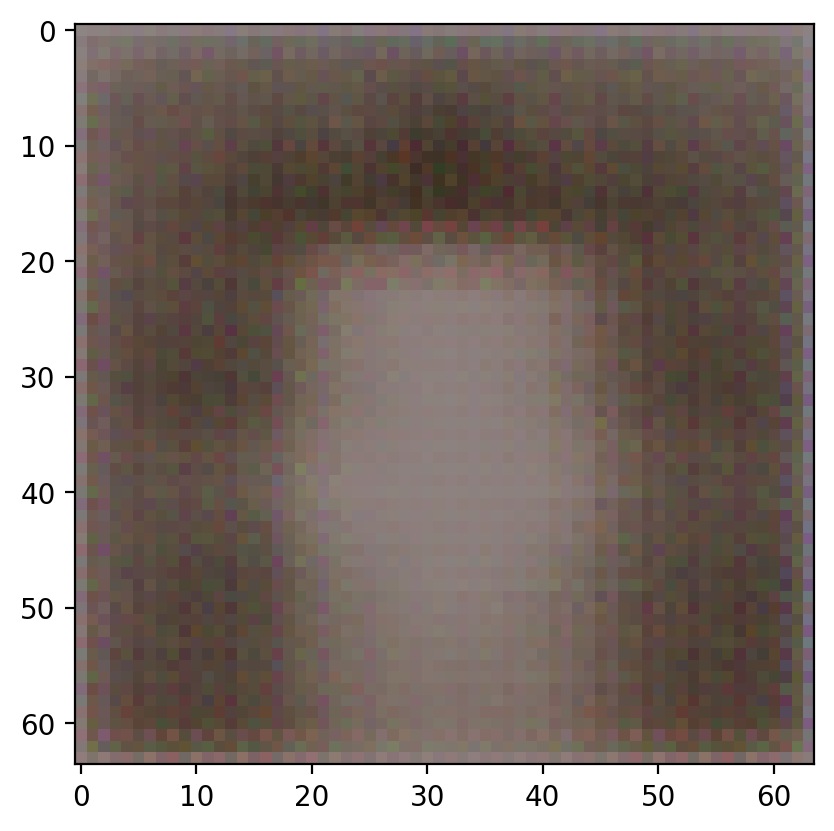

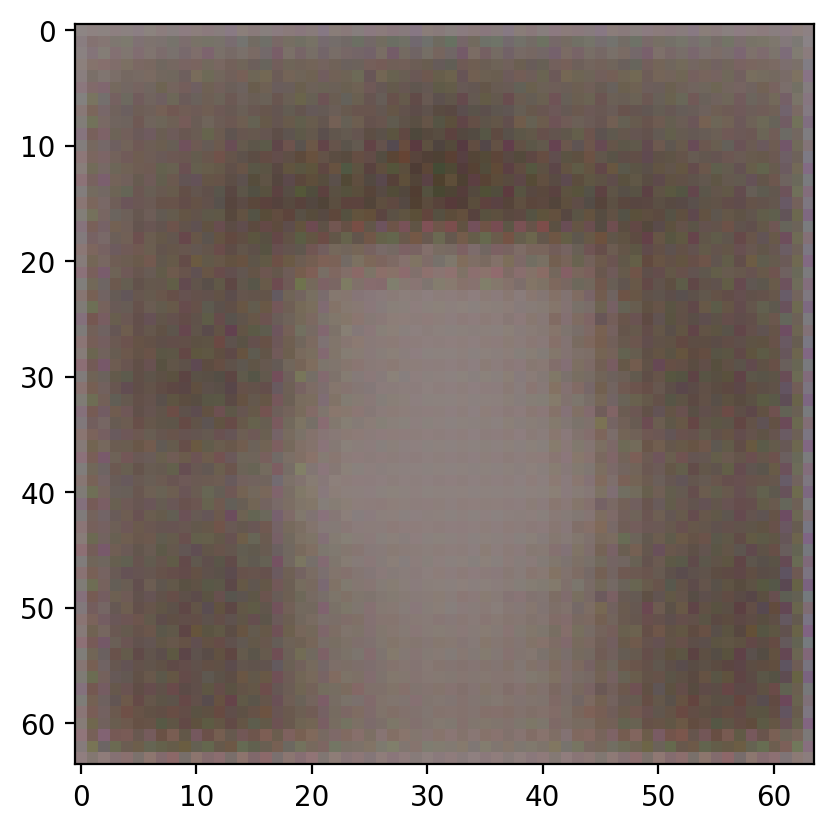

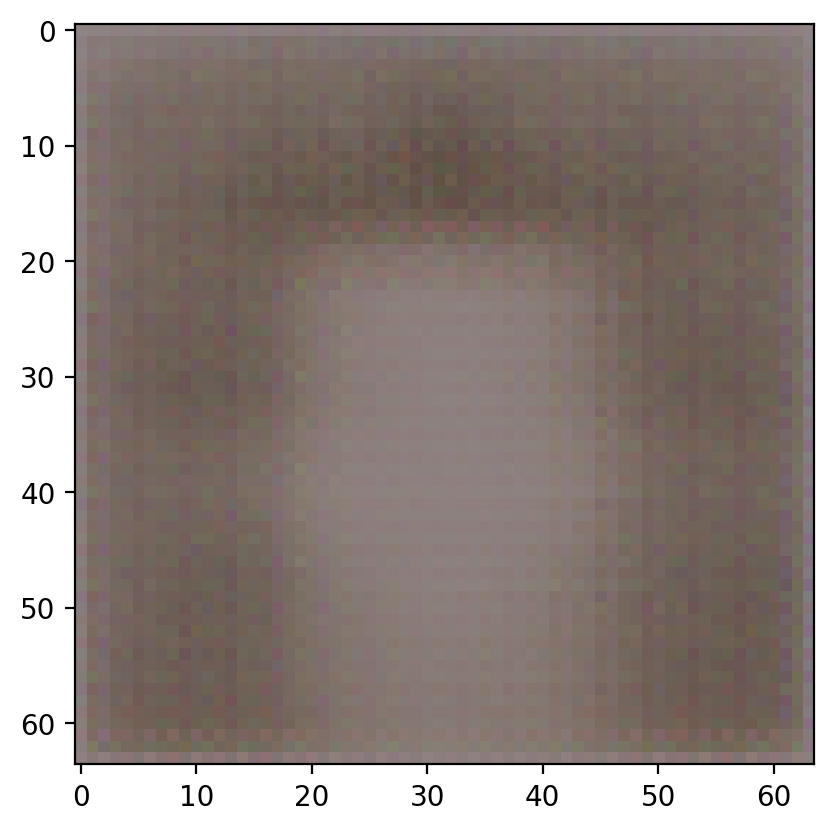

In [22]:
# Visualize all images in the reconstructed_image list
for im in reconstructed_image:
  imshow(im[0,:,:,:])   ###  iterate through each reconstructed image in the list and display it.
  ### Each element of reconstructed_image contains a batch of one image (with shape [1, channels, height, width]),
  ### and we're selecting the first (and only) image in each batch with im[0,:,:,:].

>**Exercise:** Using TSNE over `z_batch``, show how real images are projected in a 2D space. The following function is handy (it was already used in the previous lab)

In [23]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def rescale(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_latent_space_with_images(images,latent,xmin=-150,xmax=150,ymin=-150,ymax=150):

    # images --> Minibatch of images (numpy array!)
    # latent --> Matrix of 2D representations (numpy array!)

    f, ax = plt.subplots(1,1,figsize=(8, 8))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(rescale(images[i,:,:,:]))
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Latent space Z with Images')

In [24]:
z_batch.shape

torch.Size([32, 50])

In [27]:
from sklearn.manifold import TSNE

# Apply TSNE over z_batch
latent_tsne = TSNE(n_components=2).fit_transform(z_batch.cpu().detach().numpy())

In [28]:
print(f"Number of images: {i.shape[0]}")
print(f"Shape of z_batch: {z_batch.shape}")
print(f"Shape of latent_tsne: {latent_tsne.shape}")

Number of images: 32
Shape of z_batch: torch.Size([32, 50])
Shape of latent_tsne: (32, 2)


we plot all images with adjusted limits:

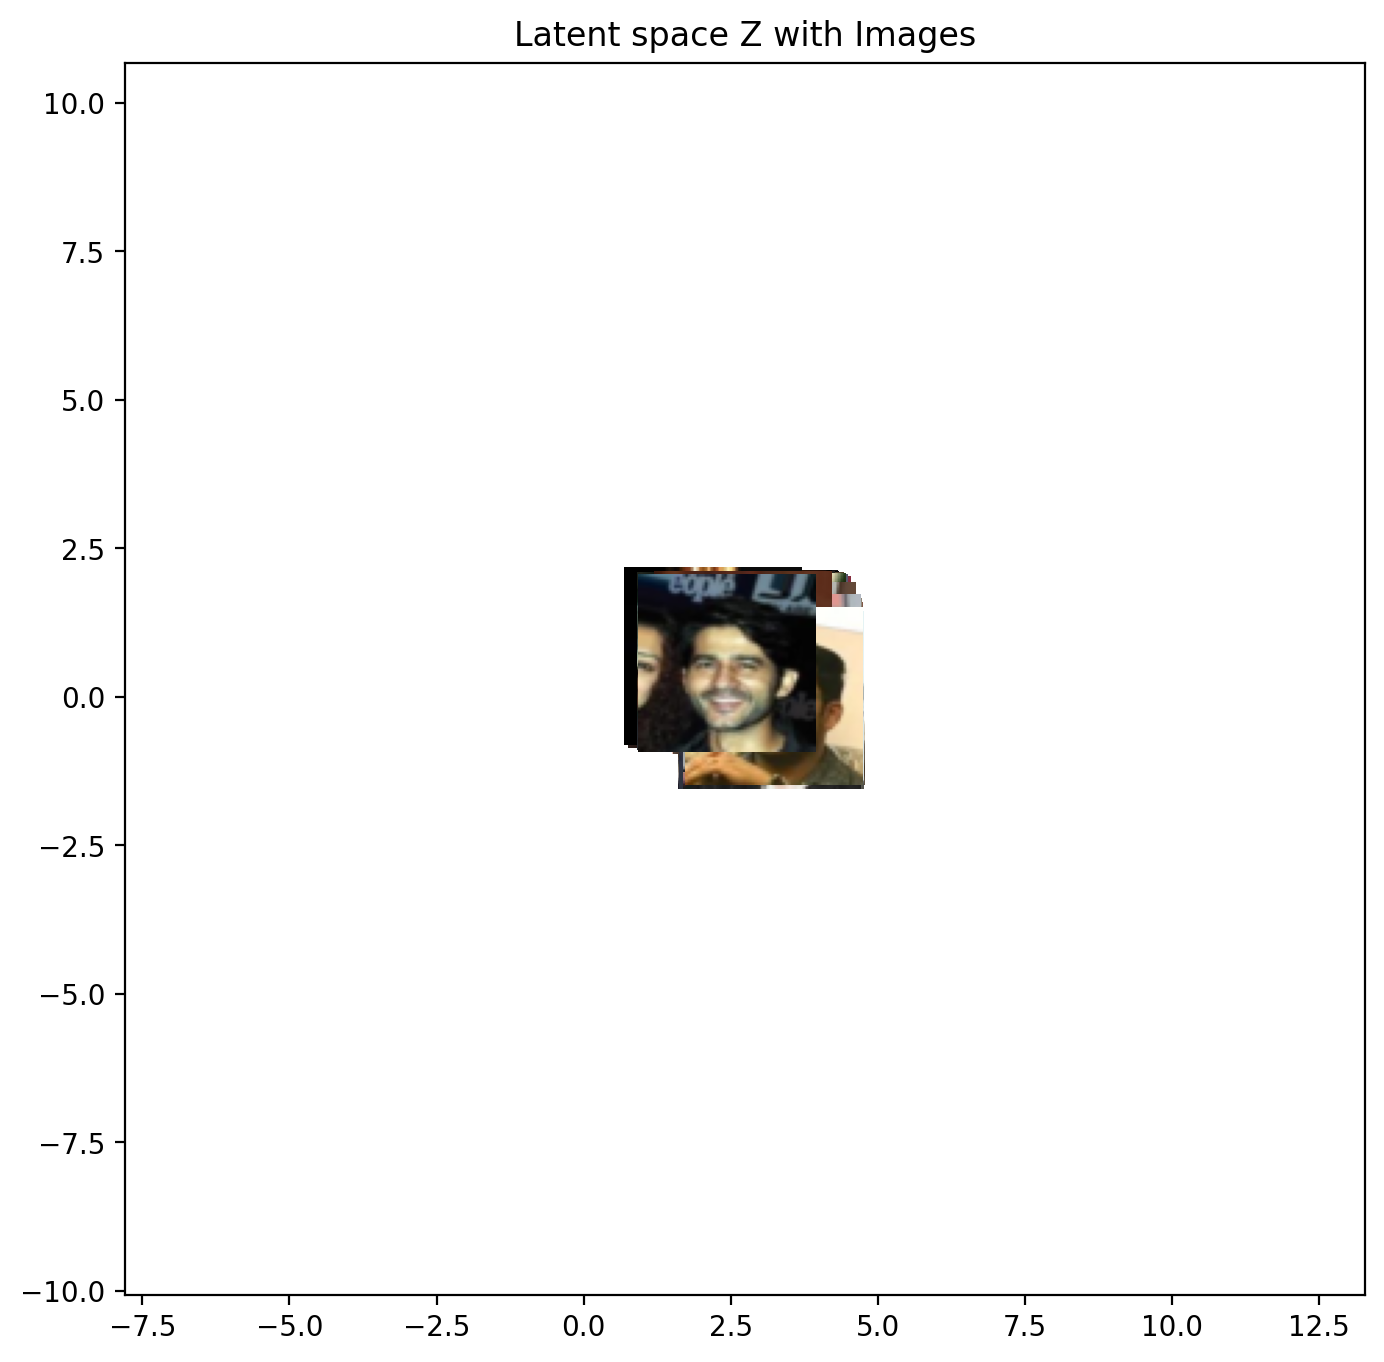

In [29]:
plot_latent_space_with_images(i, latent_tsne,
                             xmin=latent_tsne.min(0)[0]-10,
                             xmax=latent_tsne.max(0)[0]+10,
                             ymin=latent_tsne.min(0)[1]-10,
                             ymax=latent_tsne.max(0)[1]+10)

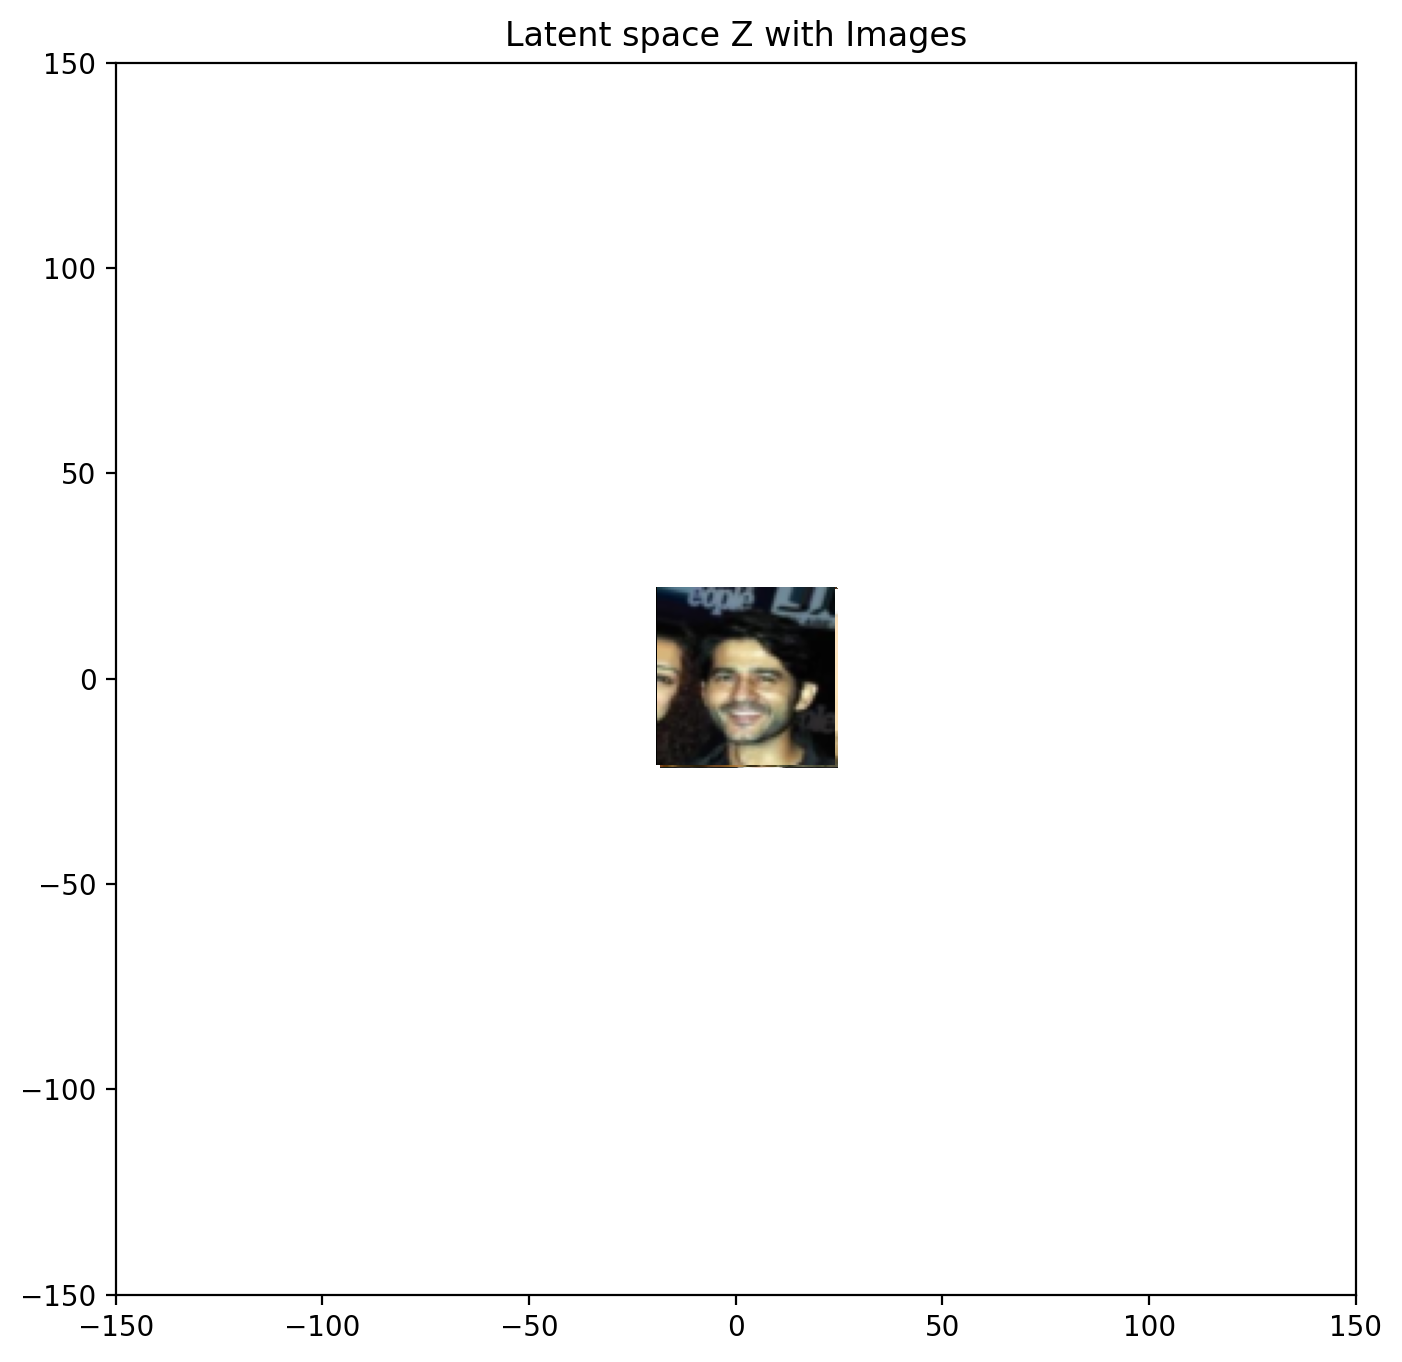

In [30]:
plot_latent_space_with_images(i, latent_tsne)

## Train the VAE from scratch

Just to finish, train your own VAE from zero for a few epochs and generate images from the model.

# PART 2

# For the remaining 0.25 points:

I want you to try implementing a VAE for synthetically generated data from a 3-dimensional Gaussian Mixture Model with several components (10 or so spread along the 3D space).

For this dataset, you can replace the CNNs in the VAE with dense layers in both the generative decoder network and the inference encoding network.

Compare the VAE samples to the ground truth distribution and evaluate how many components are effectively captured and how many modes are missing.

Using T-SNE, visualize the GMM samples in the latent space and analyze the results. Can you guess the number of components from the number of clusters in the latent space?

Deliver a report with your analysis (3 pages max) for this part.


### Import libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import seaborn as sns

In [ ]:
# Set random seed
np.random.seed(123)
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Generate synthetic data from a 3D Gaussian Mixture Model


In [ ]:
def generate_gmm_data(n_samples=10000, n_components=10):
    # Create random means in 3D space
    means = np.random.uniform(-10, 10, (n_components, 3))

    # Create random covariance matrices
    covs = np.array([np.diag(np.random.uniform(0.5, 2.0, 3)) for _ in range(n_components)])

    # Create random mixture weights
    weights = np.random.dirichlet(np.ones(n_components))

    # Sample component assignments
    components = np.random.choice(n_components, size=n_samples, p=weights)

    # Generate samples from each component
    samples = np.array([np.random.multivariate_normal(means[c], covs[c]) for c in components])

    # Save ground truth parameters for later comparison
    gmm_params = {
        'means': means,
        'covs': covs,
        'weights': weights
    }

    return samples, components, gmm_params

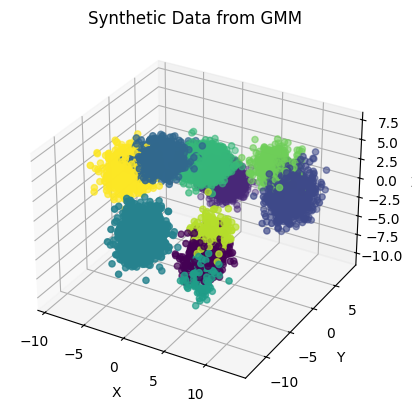

In [ ]:
# Generate synthetic data
samples, components, gmm_params = generate_gmm_data()

# Convert samples to a PyTorch tensor
samples_tensor = torch.tensor(samples, dtype=torch.float32).to(device)

# Plot the generated data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=components, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Synthetic Data from GMM')
plt.show()


<ipython-input-6-e0280745db55>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2],  cmap='viridis')


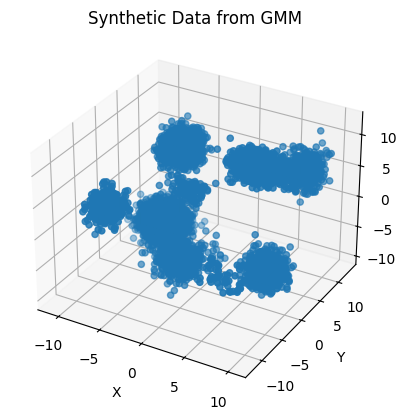

In [ ]:
# Generate synthetic data
samples, components, gmm_params = generate_gmm_data()

# Convert samples to a PyTorch tensor
samples_tensor = torch.tensor(samples, dtype=torch.float32).to(device)

# Plot the generated data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2],  cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Synthetic Data from GMM')
plt.show()


### VAE architecture with dense layers


In [ ]:
class DenseVAE(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, latent_dim=2):
        super(DenseVAE, self).__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Mean and log variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


### VAE loss and train function


In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (mean squared error)
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

def train_vae(model, dataloader, optimizer, epochs=100, beta=1.0):
    model.train()
    train_losses = []
    recon_losses = []
    kl_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

        avg_loss = epoch_loss / len(dataloader.dataset)
        avg_recon_loss = epoch_recon_loss / len(dataloader.dataset)
        avg_kl_loss = epoch_kl_loss / len(dataloader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}')

    return train_losses, recon_losses, kl_losses


### Generate samples from the VAE


In [ ]:
def generate_samples(model, n_samples=1000):
    model.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(n_samples, model.fc_mu.out_features).to(device)
        # Decode the samples
        samples = model.decode(z).cpu().numpy()
    return samples

### Fit a GMM to the generated samples to evaluate mode capture


In [ ]:
def fit_gmm_to_samples(samples, n_components_range=range(5, 15)):
    bic_scores = []
    gmm_models = []

    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(samples)
        bic_scores.append(gmm.bic(samples))
        gmm_models.append(gmm)

    best_n_components = n_components_range[np.argmin(bic_scores)]
    best_gmm = gmm_models[np.argmin(bic_scores)]

    return best_n_components, best_gmm, bic_scores

### Execute

Epoch: 10/100, Loss: 6.4909, Recon Loss: 2.5483, KL Loss: 3.9426
Epoch: 20/100, Loss: 5.8167, Recon Loss: 2.1693, KL Loss: 3.6474
Epoch: 30/100, Loss: 5.5307, Recon Loss: 2.1144, KL Loss: 3.4163
Epoch: 40/100, Loss: 5.3724, Recon Loss: 2.0758, KL Loss: 3.2966
Epoch: 50/100, Loss: 5.2768, Recon Loss: 1.9956, KL Loss: 3.2812
Epoch: 60/100, Loss: 5.2800, Recon Loss: 1.9942, KL Loss: 3.2858
Epoch: 70/100, Loss: 5.1558, Recon Loss: 1.9251, KL Loss: 3.2308
Epoch: 80/100, Loss: 5.1586, Recon Loss: 1.9149, KL Loss: 3.2436
Epoch: 90/100, Loss: 5.1096, Recon Loss: 1.9054, KL Loss: 3.2043
Epoch: 100/100, Loss: 5.0479, Recon Loss: 1.8898, KL Loss: 3.1580
True number of GMM components: 10
Detected number of GMM components: 14
Mode coverage: 140.00%


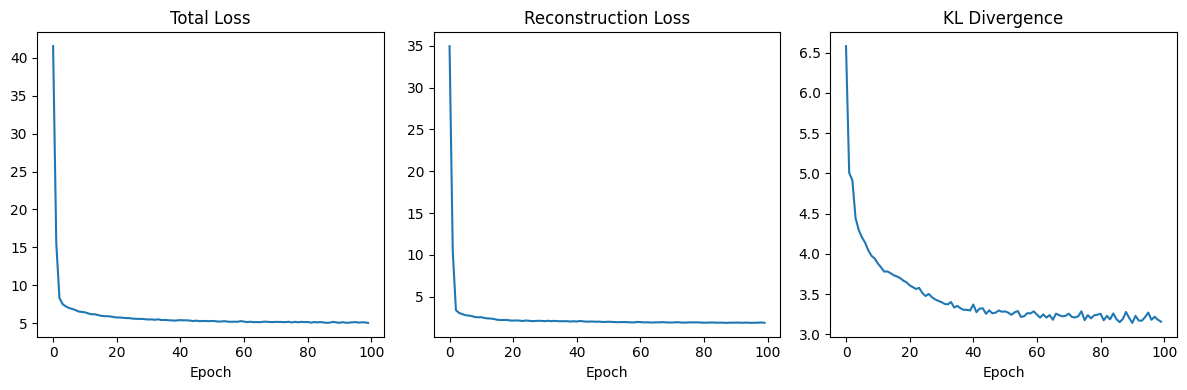

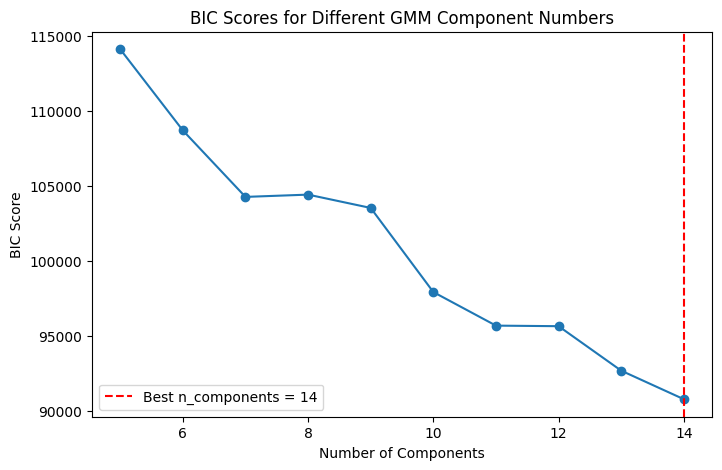

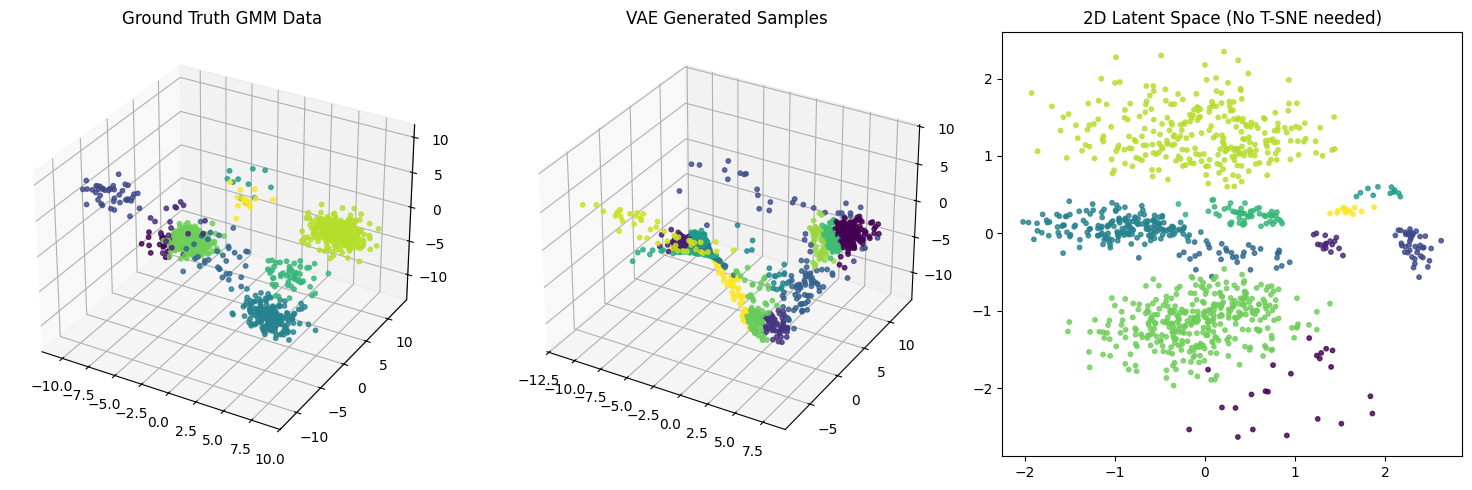

In [ ]:
def run_vae_experiment():
    # Generate synthetic data
    n_components = 10
    samples, components, gmm_params = generate_gmm_data(n_samples=10000, n_components=n_components)

    # Convert to PyTorch tensors
    data_tensor = torch.FloatTensor(samples)
    components_tensor = torch.LongTensor(components)

    # Create dataloader
    dataset = TensorDataset(data_tensor, components_tensor)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Initialize the VAE model
    input_dim = 3  # 3D GMM data
    hidden_dim = 128
    latent_dim = 2  # We'll use 2D latent space for easier visualization

    model = DenseVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train the VAE
    train_losses, recon_losses, kl_losses = train_vae(model, dataloader, optimizer, epochs=100, beta=1.0)

    # Plot the loss curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Total Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 3, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 3, 3)
    plt.plot(kl_losses)
    plt.title('KL Divergence')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('vae_loss_curves.png')

    # Generate samples from the VAE
    vae_samples = generate_samples(model, n_samples=10000)

    # Fit GMM to the generated samples to detect modes
    best_n_components, best_gmm, bic_scores = fit_gmm_to_samples(vae_samples)

    # Plot BIC scores
    plt.figure(figsize=(8, 5))
    plt.plot(range(5, 15), bic_scores, 'o-')
    plt.axvline(x=best_n_components, color='r', linestyle='--',
                label=f'Best n_components = {best_n_components}')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Score')
    plt.title('BIC Scores for Different GMM Component Numbers')
    plt.legend()
    plt.savefig('gmm_bic_scores.png')

    # Visualize ground truth vs VAE samples in 3D
    fig = plt.figure(figsize=(15, 5))

    # Ground truth data
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(samples[:1000, 0], samples[:1000, 1], samples[:1000, 2], c=components[:1000], s=10, alpha=0.8)
    ax1.set_title('Ground Truth GMM Data')

    # VAE generated samples
    ax2 = fig.add_subplot(132, projection='3d')
    vae_labels = best_gmm.predict(vae_samples[:1000])
    ax2.scatter(vae_samples[:1000, 0], vae_samples[:1000, 1], vae_samples[:1000, 2], c=vae_labels, s=10, alpha=0.8)
    ax2.set_title('VAE Generated Samples')

    # T-SNE of the latent space
    with torch.no_grad():
        encoded_data, _ = model.encode(data_tensor.to(device))
        encoded_data = encoded_data.cpu().numpy()

    ax3 = fig.add_subplot(133)
    scatter = ax3.scatter(encoded_data[:1000, 0], encoded_data[:1000, 1], c=components[:1000], s=10, alpha=0.8)
    ax3.set_title('2D Latent Space (No T-SNE needed)')

    plt.tight_layout()
    plt.savefig('vae_gmm_comparison.png')

    # T-SNE visualization if latent_dim > 2
    if latent_dim > 2:
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(encoded_data)

        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=components, s=10, alpha=0.8)
        plt.title('T-SNE of Latent Space')
        plt.colorbar()
        plt.savefig('tsne_latent_space.png')

    # Analyze mode coverage and return results
    analysis_results = {
        'true_n_components': n_components,
        'detected_n_components': best_n_components,
        'mode_coverage': best_n_components / n_components
    }

    return analysis_results

# Run the experiment and print results
if __name__ == "__main__":
    results = run_vae_experiment()
    print(f"True number of GMM components: {results['true_n_components']}")
    print(f"Detected number of GMM components: {results['detected_n_components']}")
    print(f"Mode coverage: {results['mode_coverage'] * 100:.2f}%")